# Improving Accuracy of Energy Timeseries Forecasts EnBW Datalab

In [116]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import os
import torch
from torch.utils.data import Dataset, DataLoader


In [117]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data
        #self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        #y = self.labels[index]
        return x, y

In [118]:

display_size = 70000

In [119]:
data = pd.read_csv("./timeseries_data/trafo_56.csv")
data["timestamp"] = pd.to_datetime(data["timestampUtc"])
data_modified = data.drop(columns=["timestampUtc"]).set_index("timestamp")

In [120]:
freq = pd.infer_freq(data_modified.index)
print("Frequency consistency of data: ", freq)

Frequency consistency of data:  15T


In [121]:
#pd.set_option('display.max_rows', None)
#pd.reset_option('display.max_rows')

In [122]:
data_modified

,value,t_2mc,aswdifd_s,aswdir_s,vmax_10m,tot_prec
timestamp,,,,,,
2021-10-01 00:00:00+00:00,-1.354663,7.289917,0.0,0.0,5.953429,0.0
2021-10-01 00:15:00+00:00,-1.363853,7.289917,0.0,0.0,5.953429,0.0
2021-10-01 00:30:00+00:00,-1.435403,7.289917,0.0,0.0,5.953429,0.0
2021-10-01 00:45:00+00:00,-1.430808,7.289917,0.0,0.0,5.953429,0.0
2021-10-01 01:00:00+00:00,-1.447218,7.425018,0.0,0.0,5.907781,0.0
...,...,...,...,...,...,...
2023-09-30 23:00:00+00:00,-1.335627,13.015503,0.0,0.0,5.967246,0.0
2023-09-30 23:15:00+00:00,-1.297554,13.015503,0.0,0.0,5.967246,0.0
2023-09-30 23:30:00+00:00,-1.356632,13.015503,0.0,0.0,5.967246,0.0


In [123]:
# Check for Missing Values

nan_values = data_modified.isna().sum()
# Display the result
print("NaN values in each column of original data:")
print(nan_values)

NaN values in each column of original data:
value        4718
t_2mc           0
aswdifd_s       0
aswdir_s        0
vmax_10m        0
tot_prec        0
dtype: int64


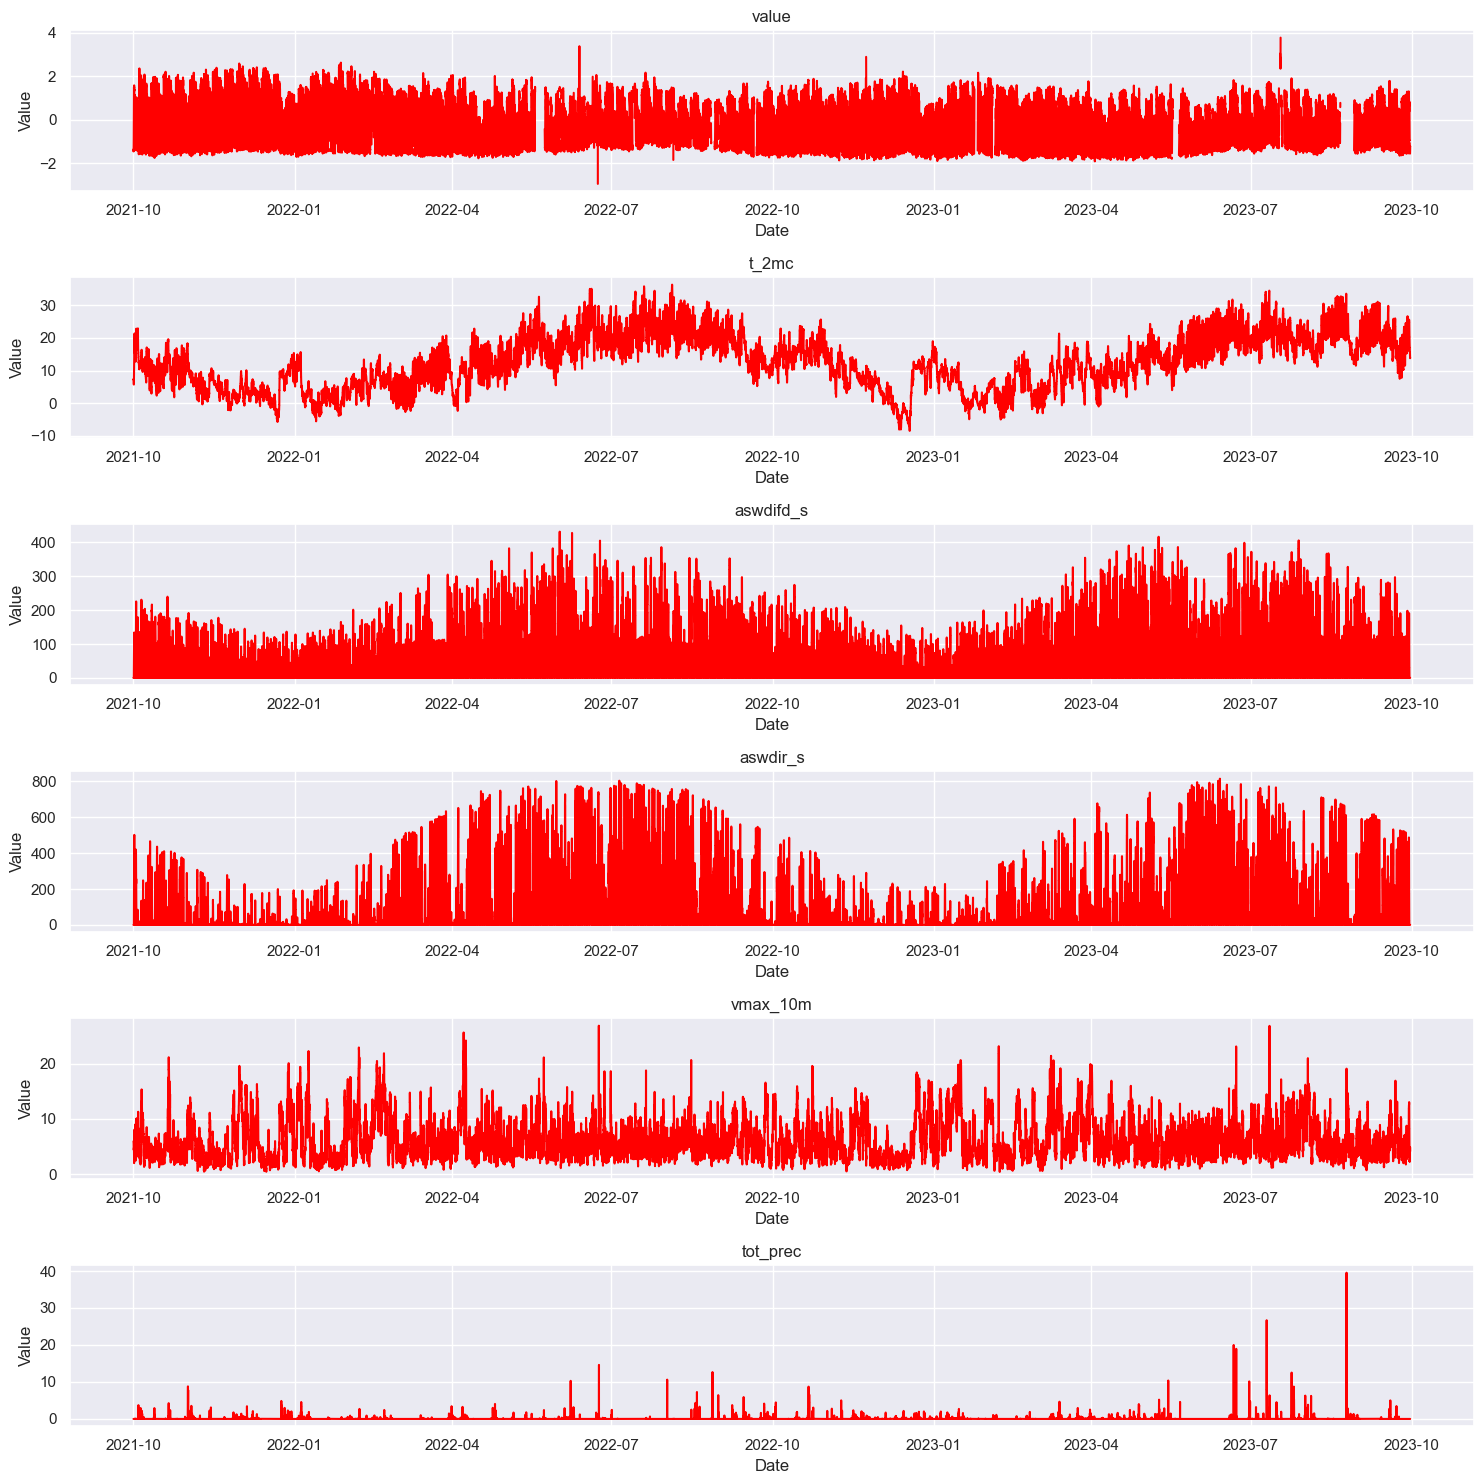

In [124]:
# Size of rows to be displayed


fig, axes = plt.subplots(6, 1, figsize=(15, 15))
axes = axes.flatten()

for i, column in enumerate(data_modified.columns):
    ax = axes[i]
    ax.plot(data_modified.head(display_size).index, data_modified.head(display_size)[column], color='red')
    ax.set_title(column)
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [125]:
# Interpolate missing values

data_modified_1 = data_modified.copy()
data_modified_1 = data_modified_1.interpolate(method='cubic', limit_direction='both')  

for col in data_modified_1:
            max_val_before = data_modified[col].max()
            min_val_before = data_modified[col].min()
            data_modified_1[col] = data_modified_1[col].clip(upper=max_val_before, lower=min_val_before)
            
    

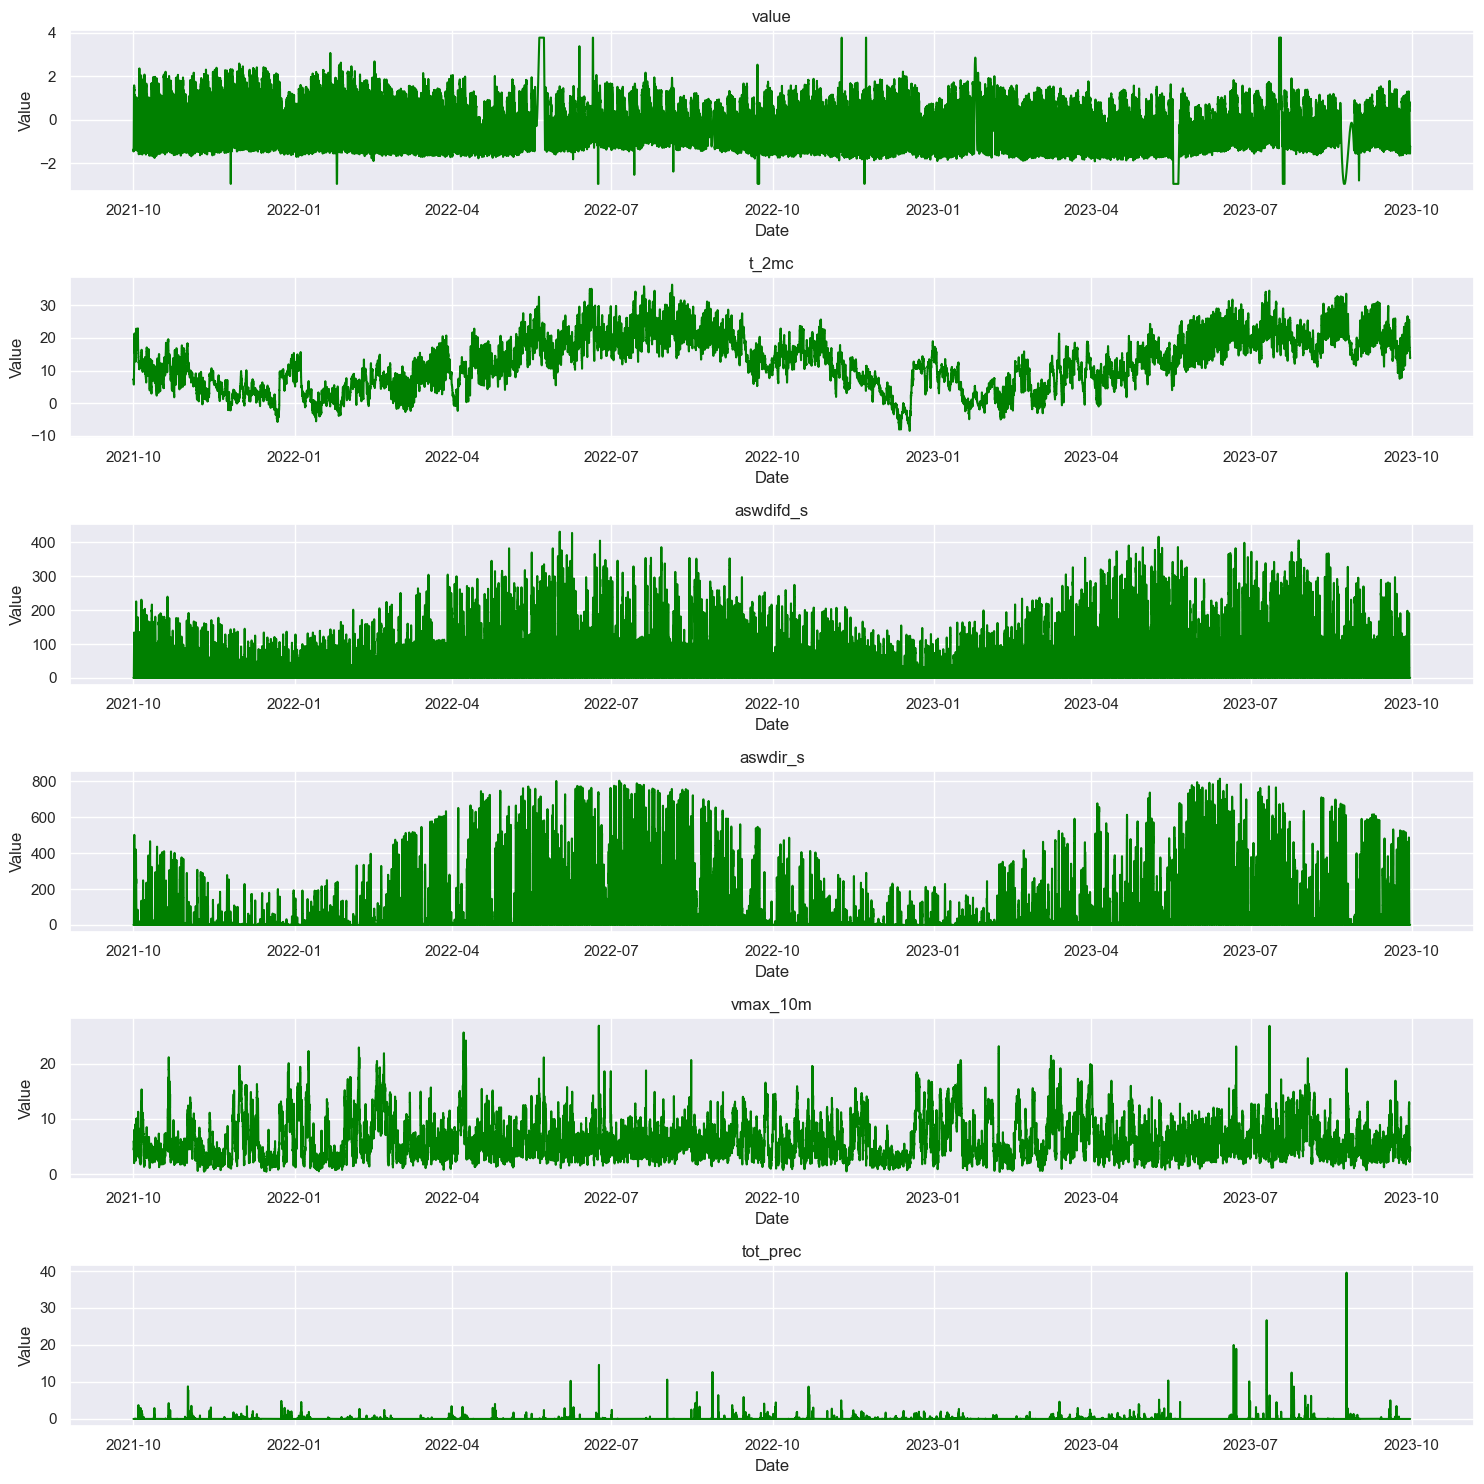

In [126]:
# Size of rows to be displayed

fig, axes = plt.subplots(6, 1, figsize=(15, 15))
axes = axes.flatten()

for i, column in enumerate(data_modified_1.columns):
    ax = axes[i]
    ax.plot(data_modified_1.head(display_size).index, data_modified_1.head(display_size)[column], color='green')
    ax.set_title(column)
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [127]:
# Checking Outliers: Z Score


z = np.abs(stats.zscore(data_modified[data_modified.select_dtypes(include=[np.number]).columns]))
data_modified_2 = data_modified.mask((z > 3))
data_modified_2


nan_values_1 = data_modified_2.isna().sum()

# Display the result
print("NaN values in each column of data after outlier detection:")
print(nan_values_1)


NaN values in each column of data after outlier detection:
value        4718
t_2mc           0
aswdifd_s     940
aswdir_s     2004
vmax_10m      748
tot_prec      568
dtype: int64


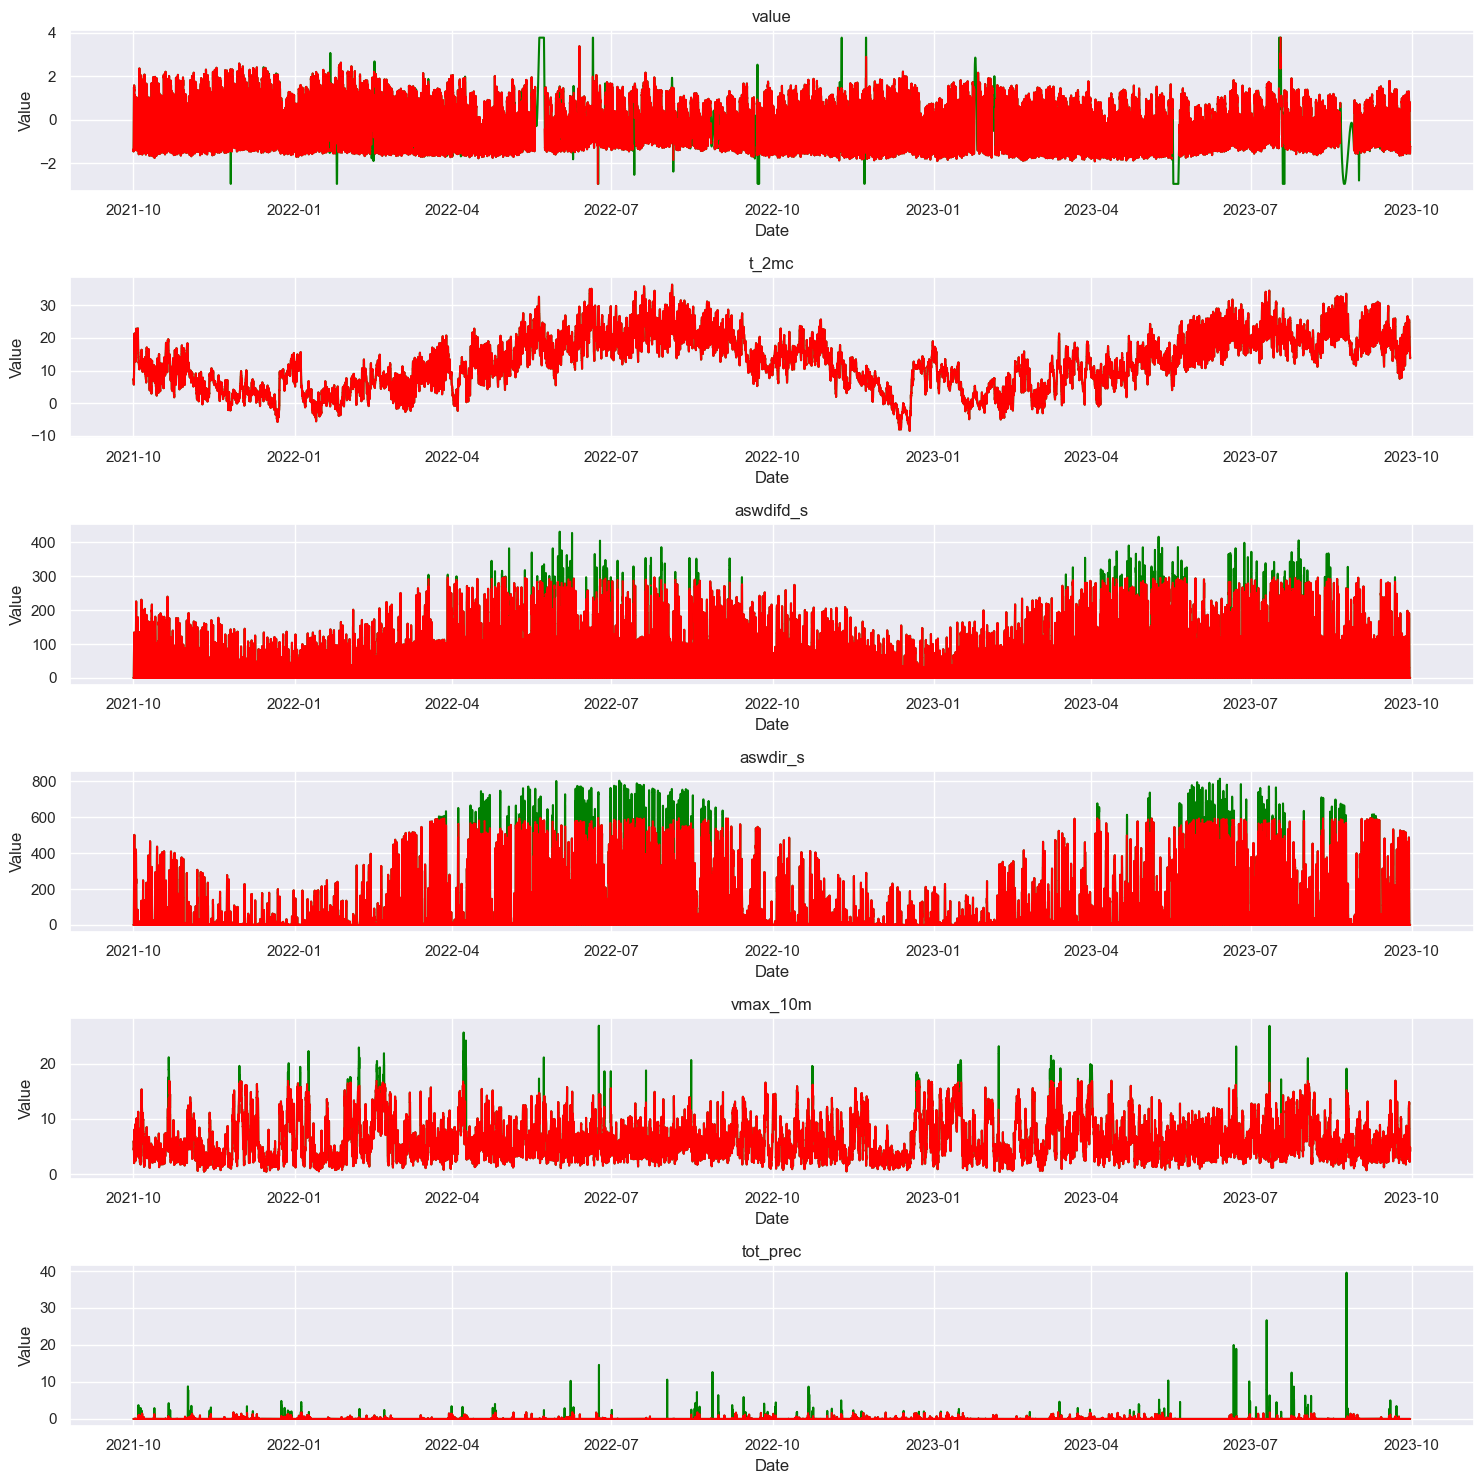

In [128]:
# Size of rows to be displayed

fig, axes = plt.subplots(6, 1, figsize=(15, 15))
axes = axes.flatten()

for i, column in enumerate(data_modified_2.columns):
    ax = axes[i]
    ax.plot(data_modified_1.head(display_size).index, data_modified_1.head(display_size)[column], color='green')
    ax.plot(data_modified_2.head(display_size).index, data_modified_2.head(display_size)[column], color='red')
    ax.set_title(column)
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [129]:
# Checking Outliers: Percentile

L_Q = data_modified.select_dtypes(include=[np.number]).quantile(0.15, interpolation="nearest")
U_Q = data_modified.select_dtypes(include=[np.number]).quantile(0.85, interpolation="nearest")
data_modified_3 = data_modified.mask((data_modified.select_dtypes(include=[np.number]) > U_Q) | (data_modified.select_dtypes(include=[np.number]) < L_Q))
data_modified_3

nan_values_2 = data_modified_3.isna().sum()

# Display the result
print("NaN values in each column of data after outlier detection:")
print(nan_values_2)

NaN values in each column of data after outlier detection:
value        24268
t_2mc        21024
aswdifd_s    10512
aswdir_s     10512
vmax_10m     21024
tot_prec     10392
dtype: int64


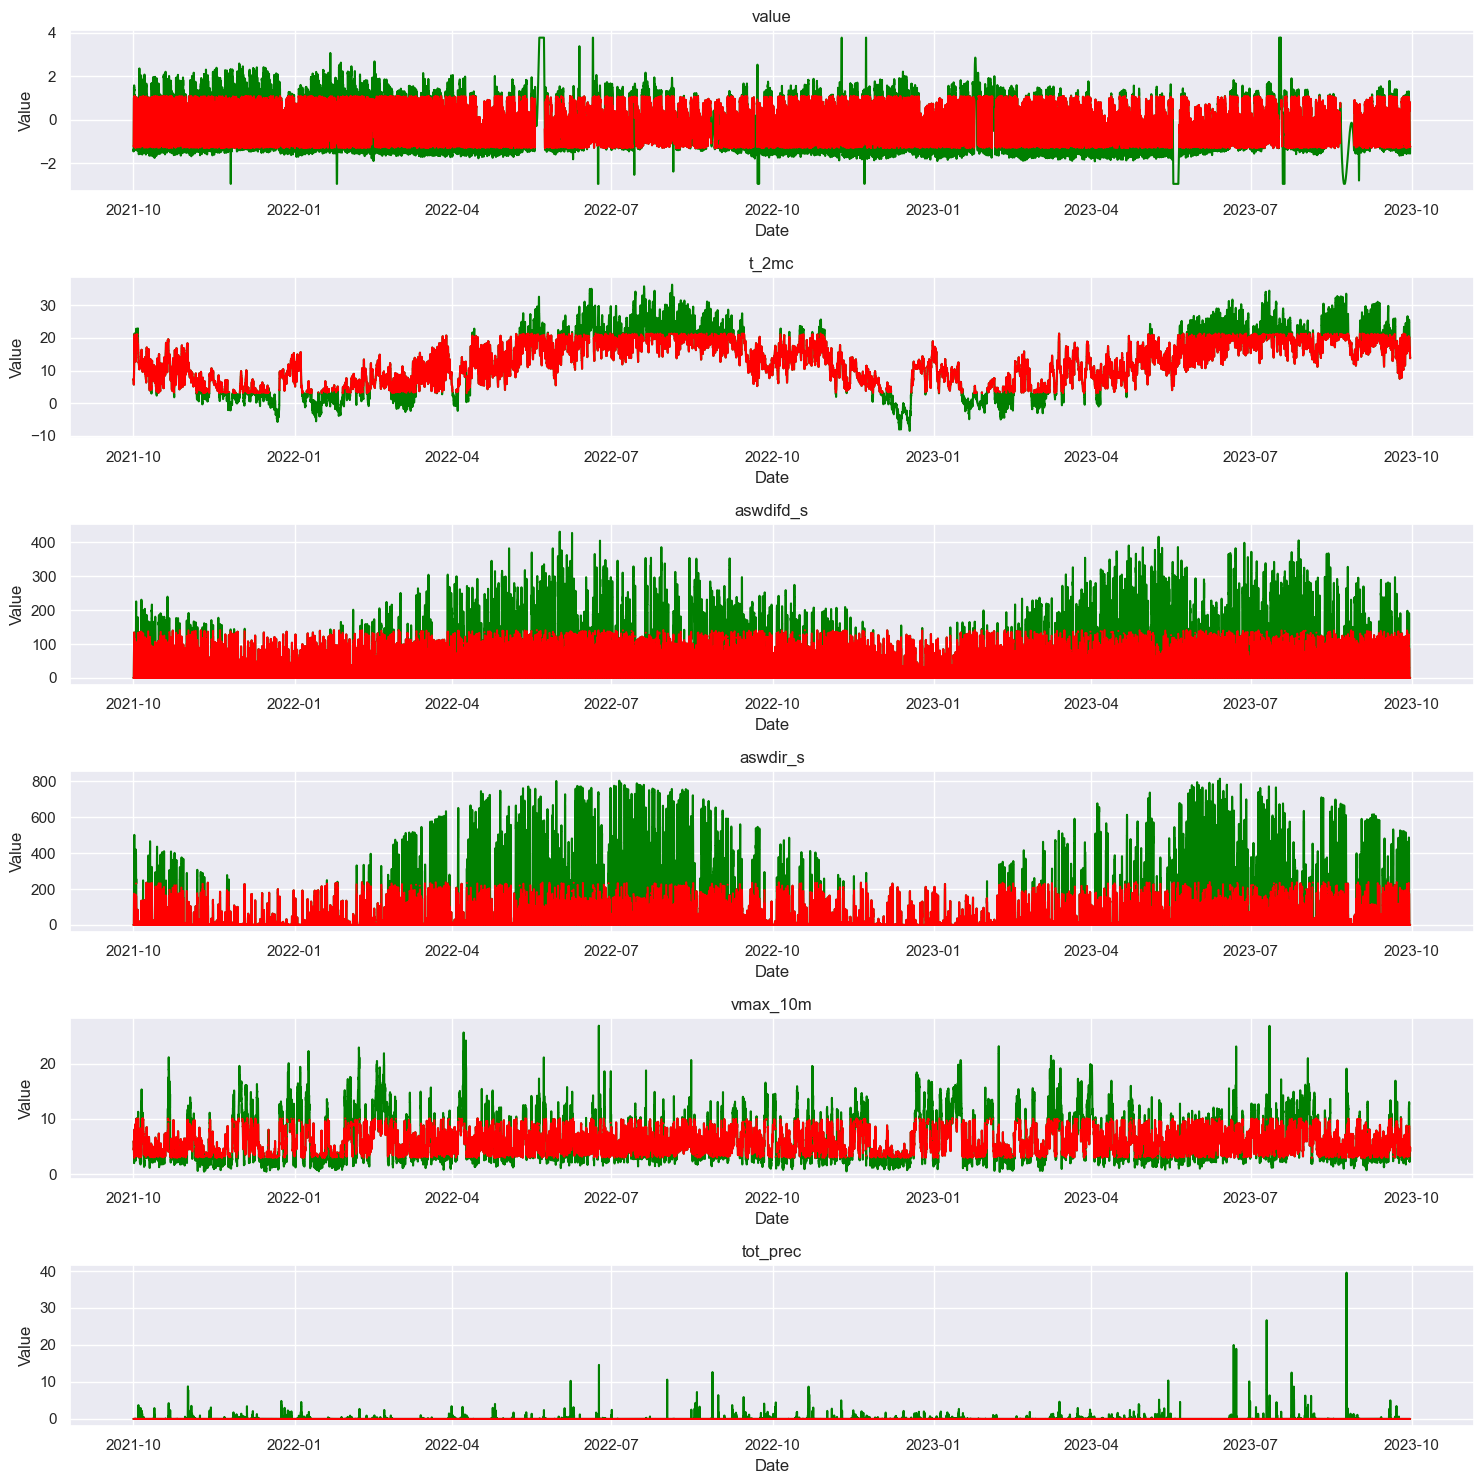

In [130]:


fig, axes = plt.subplots(6, 1, figsize=(15, 15))
axes = axes.flatten()

for i, column in enumerate(data_modified_2.columns):
    ax = axes[i]
    ax.plot(data_modified_1.head(display_size).index, data_modified_1.head(display_size)[column], color='green')
    ax.plot(data_modified_3.head(display_size).index, data_modified_3.head(display_size)[column], color='red')
    ax.set_title(column)
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

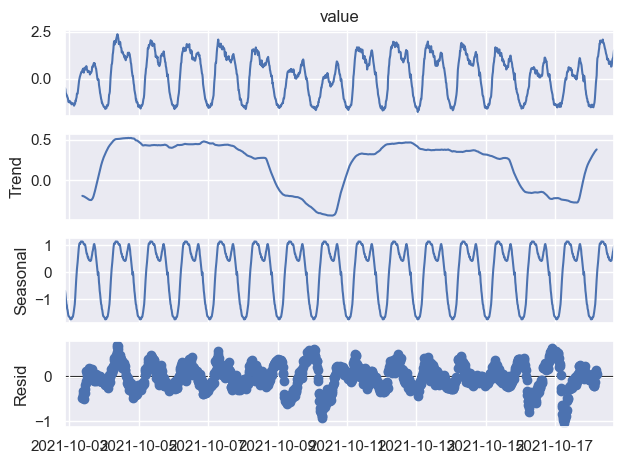

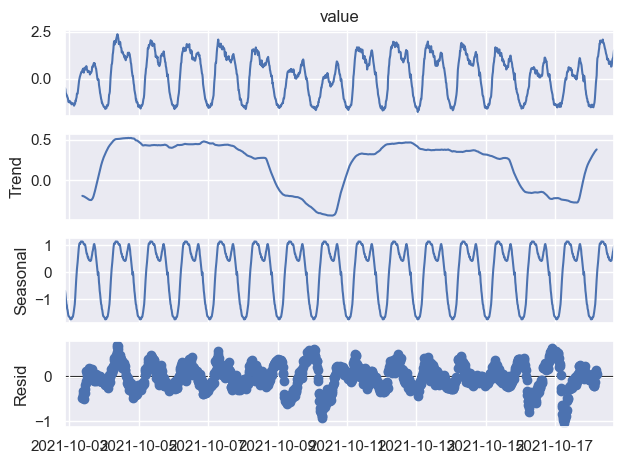

In [131]:
plot1 = seasonal_decompose(data_modified_1["value"][180:1700], model='additive', filt=None, period=96, extrapolate_trend=0)
plot1.plot()

#The daily seasonality repeats itself every 24 hours.

In [132]:
# Instantiate Dataset:
training_data = CustomDataset(pd.read_csv("./timeseries_data/trafo_56.csv"))
testing_data = CustomDataset(pd.read_csv("./timeseries_data/trafo_57.csv"))

In [133]:
batch_size = 7000
shuffle = True



train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(testing_data, batch_size=batch_size)

In [134]:
import numpy as np


def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)


# Compute Fourier features to the 4th order (8 new features) for a
# series y with daily observations and annual seasonality:
#
# fourier_features(y, freq=365.25, order=4)

In [135]:
import seaborn as sns; sns.set()


In [136]:
# Calculation of moving averages of individual measurement parameters
for column in data_modified_1:
    data_modified_1['SMA168 ' + column] = data_modified_1[column].rolling('100h', center = True).mean()

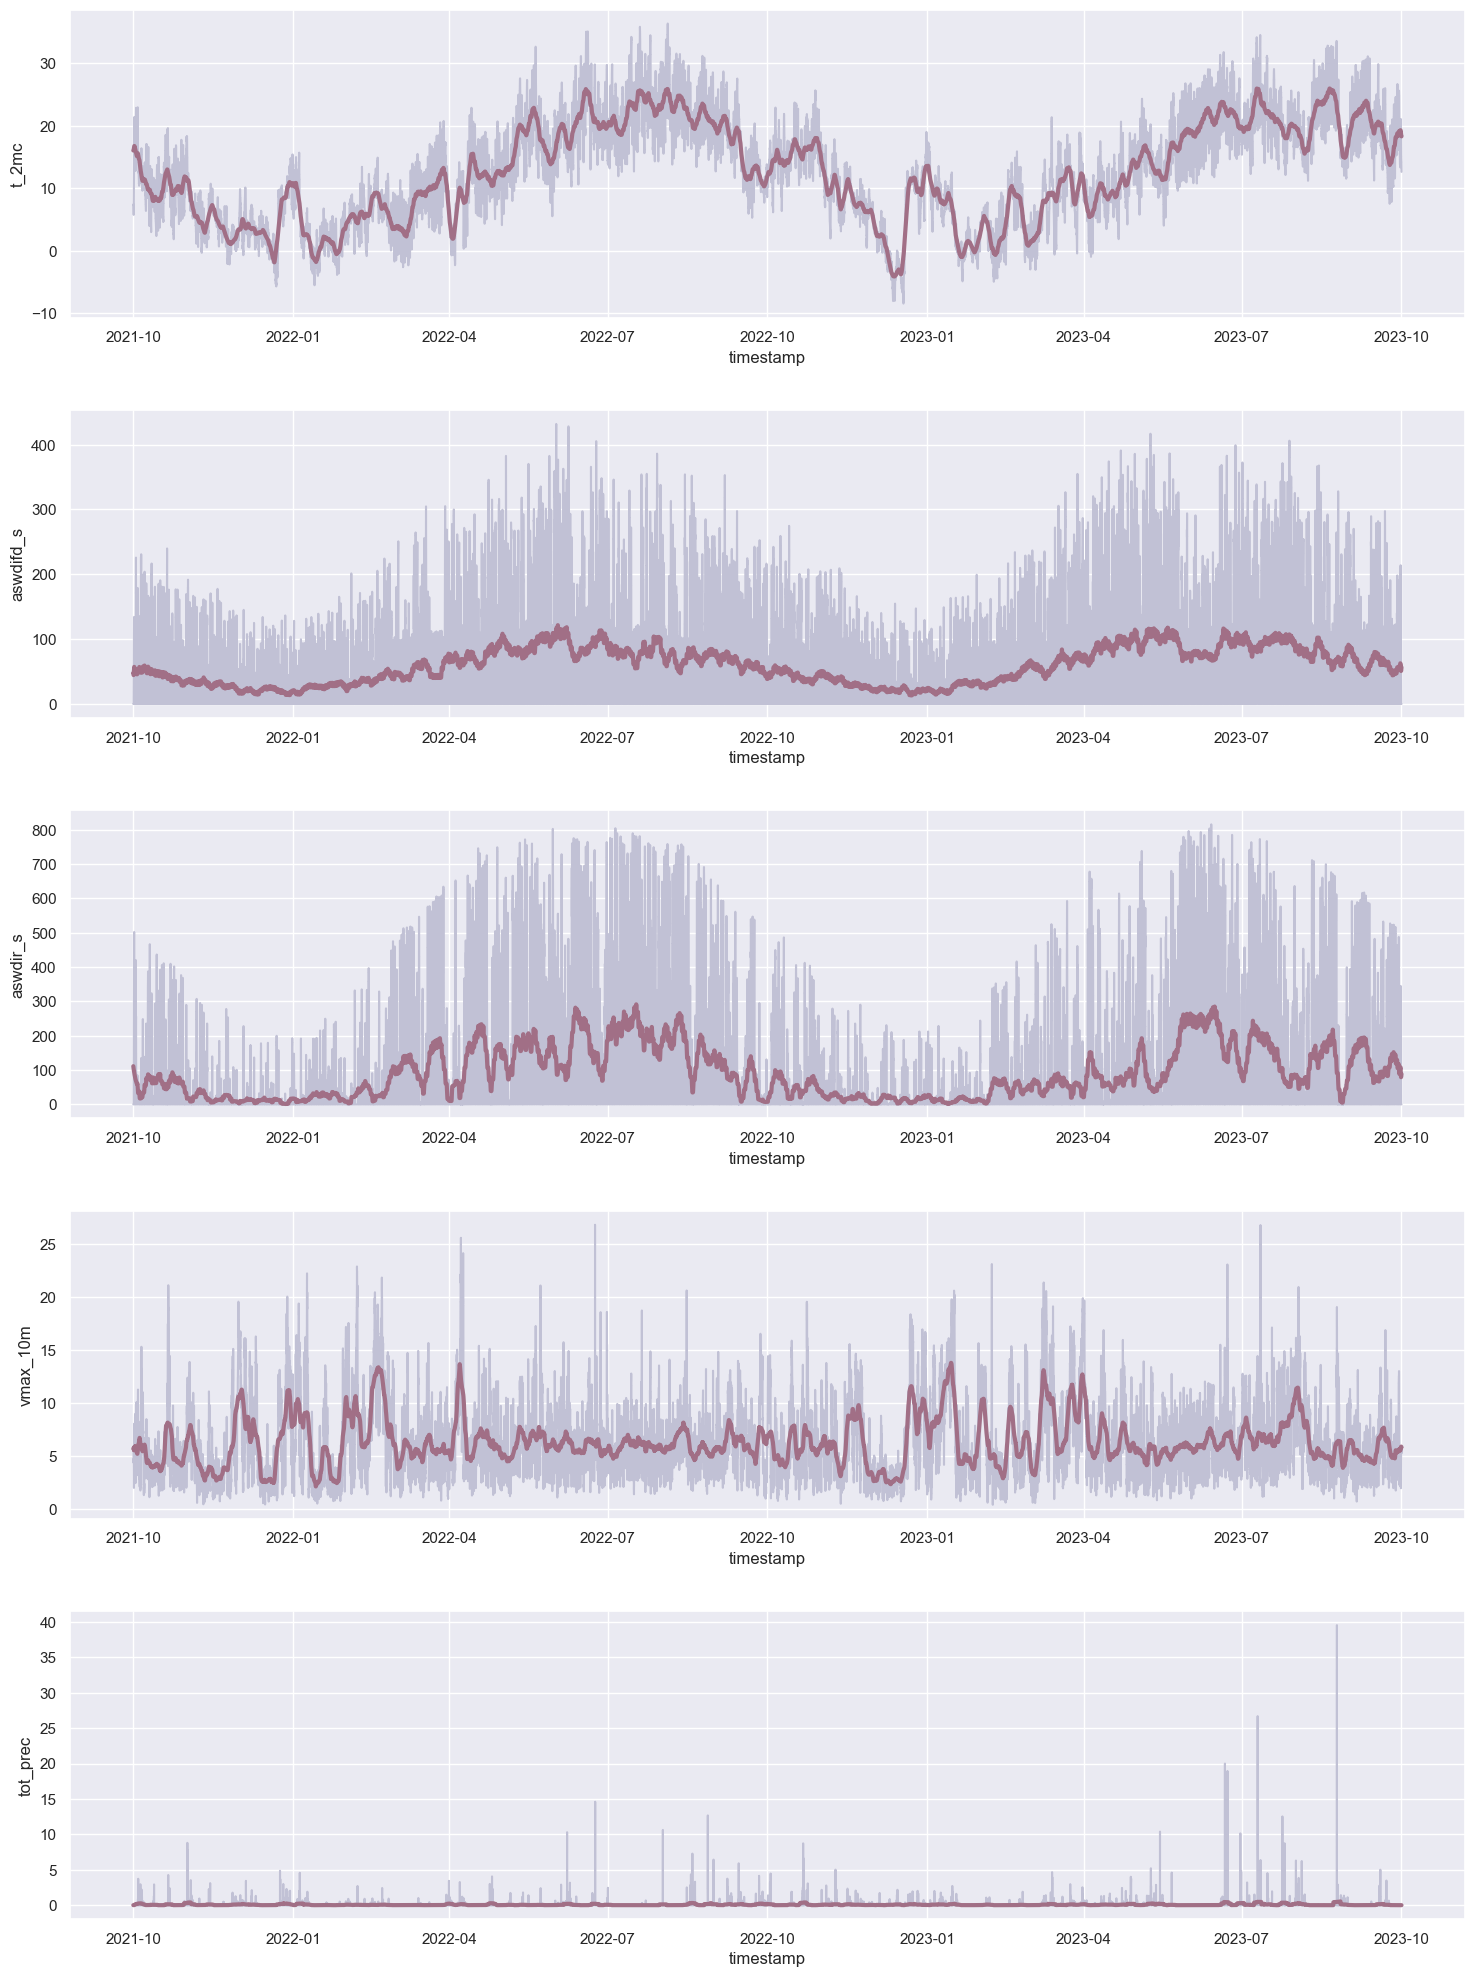

In [137]:
# Display line graphs

color_2 = '#C1C1D5'
color_3 = '#A16F86'

plt.figure(figsize = (18, 30)) 
plt.subplot(611)
sns.lineplot(data = data_modified_1, x = 'timestamp', y = 't_2mc', color = color_2)
sns.lineplot(data = data_modified_1, x = 'timestamp', y = 'SMA168 t_2mc', color = color_3, lw = 3)

plt.subplot(612)
sns.lineplot(data = data_modified_1, x = 'timestamp', y = 'aswdifd_s', color = color_2)
sns.lineplot(data = data_modified_1, x = 'timestamp', y = 'SMA168 aswdifd_s', color = color_3, lw = 3)

plt.subplot(613)
sns.lineplot(data = data_modified_1, x = 'timestamp', y = 'aswdir_s', color = color_2)
sns.lineplot(data = data_modified_1, x = 'timestamp', y = 'SMA168 aswdir_s', color = color_3, lw = 3)

plt.subplot(614)
sns.lineplot(data = data_modified_1, x = 'timestamp', y = 'vmax_10m', color = color_2)
sns.lineplot(data = data_modified_1, x = 'timestamp', y = 'SMA168 vmax_10m', color = color_3, lw = 3)

plt.subplot(615)
sns.lineplot(data = data_modified_1, x = 'timestamp', y = 'tot_prec', color = color_2)
sns.lineplot(data = data_modified_1, x = 'timestamp', y = 'SMA168 tot_prec', color = color_3, lw = 3)



plt.subplots_adjust(hspace = 0.3)
plt.show()

In [138]:
import lightgbm as lgb